In [1]:
import pandas as pd
import torch, torchdata, torchtext
from torch import nn
import time
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

#make our work comparable if restarted the kernel
SEED = 2422
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

c:\Users\anhng\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cpu


In [2]:
torch.__version__

'1.13.1+cpu'

In [3]:
torchtext.__version__

'0.14.1'

## Load the given dataset

1. Create a variable to your dataset PATH *example:  ./data/*
2. Load the csv files using pandas 



In [4]:
train_data_raw = pd.read_csv("./dataset/train.csv")
test_data_raw = pd.read_csv("./dataset/test.csv")


In [5]:
train_data_raw.shape

(7613, 5)

In [6]:
test_data_raw.shape

(3263, 4)

In [7]:
## Lets analyze the data a little

#print and show how many unique classes are in the target

classes     = train_data_raw["target"].unique()
num_classes = len(classes)

print("Number of unique classes in the target:", num_classes)

Number of unique classes in the target: 2


In [8]:
assert num_classes > 1

In [9]:
##lets see how many columns are there
#print the columns of the train_data_raw

print(train_data_raw.columns) #write your code here

Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')


1. Lets remove the keywords and location columns. We only want to focus on the text and the predictions
2. Lets split some training data to validation dataset

In [10]:
SPLIT_PER = 2 #percentage of split for validation set 2 = 2%
split =  int(len(train_data_raw) * (SPLIT_PER/100))

# dropped_train = #drop the id, keyowrd and location columns from the train_data_raw
dropped_train = train_data_raw.drop(['id', 'keyword', 'location'], axis=1)

train_data = dropped_train[:-split]
valid_data = dropped_train[-split:]

assert train_data.shape == (len(train_data_raw) - split, 2)
assert valid_data.shape == (split, 2)

In [11]:
print(train_data_raw.shape)
print("After dropping columns and spliting!")
print(train_data.shape, valid_data.shape)
 

(7613, 5)
After dropping columns and spliting!
(7461, 2) (152, 2)


## Lets tokenize the data

In [12]:
from torchtext.data.utils import get_tokenizer

tokenizer = get_tokenizer('spacy', language='en_core_web_md')
 
tokens = tokenizer("We are learning torchtext in AIT!")  #some test
tokens

['We', 'are', 'learning', 'torchtext', 'in', 'AIT', '!']

In [13]:
from torchtext.vocab import build_vocab_from_iterator

def yield_tokens(data_iter):
    #loop through the data_iter, 
    # Mind that the data_iter in this case is pandas Dataframe
    for text in data_iter["text"]:
        yield tokenizer(text)

specials = ['<unk>', '<pad>', '<bos>', '<eos>'] #create array of special tags for the vocab
vocab  = build_vocab_from_iterator(yield_tokens(train_data), specials = specials, special_first=True)

#set_default_index of the vocab to unknown tag
vocab.set_default_index(vocab["<unk>"]) 

In [14]:
assert len(vocab) == 26442

In [15]:
vocab_dict = vocab.get_stoi()
vocab_dict

{'bells': 17043,
 'Escaping': 12472,
 'charge': 2966,
 "'m": 59,
 'putin': 24713,
 'adoption': 6850,
 'STILL': 6529,
 'WOUNDS': 16371,
 'Mafia': 6212,
 'mass': 200,
 'Lubbock': 6184,
 'Gillibrand': 12913,
 'Scarlet': 15416,
 'depreciations': 17800,
 'Bomb': 1013,
 '@WoundedPigeon': 9949,
 'lvl': 23796,
 'advice': 16695,
 '.': 6,
 'restore': 3119,
 'dominant': 17956,
 'thunder': 475,
 '.@NorwayMFA': 8190,
 'pitch': 3866,
 '@9NewsBrisbane': 8744,
 'Odell': 14460,
 'Quarantine': 761,
 'point': 1142,
 '@ByTorrecilla': 8925,
 'fruit': 3025,
 'Some': 319,
 '&': 38,
 '@charstevens97': 10132,
 'http://t.co/JlzK2HdeTG': 7409,
 'Officer': 1265,
 'LLF': 6136,
 'WYOU': 16392,
 'US': 245,
 '...': 18,
 '@SCynic1': 9707,
 'WIN': 16358,
 'appropriation': 6878,
 'Join': 2411,
 '<bos>': 2,
 'illegal': 2239,
 'threat': 1818,
 'Zhejiang': 16615,
 'en\x89Û': 7222,
 'asswipe': 16889,
 'Reactor': 2454,
 '<unk>': 0,
 'suspect': 749,
 'Andrea': 11042,
 'Minority': 4427,
 'illusion': 23303,
 'http://t.co/0wbEcd

In [16]:
from torchtext.vocab import FastText
fast_vectors = FastText(language='simple') ##Load fasttext with language=simple

In [17]:
fast_embedding = fast_vectors.get_vecs_by_tokens(vocab.get_itos()).to(device)

#since the fasttext  has 300 embedding
assert fast_embedding.shape == (len(vocab), 300)

In [18]:
text_pipeline = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: int(x)  ## Copy from the lab. Note that Something has to be changed

In [19]:
text_pipeline("I love to play football")

[13, 185, 10, 683, 2229]

In [20]:
label_pipeline('1')

1

## To fit the pandas dataframe to DataLoader first we must wrap it as DataSet

In [21]:

from torch.utils.data import Dataset

class PD_DATASET(Dataset):

    def __init__(self, dataframe):
        self.dataframe = dataframe
    
    def __len__(self):
        return len(self.dataframe)
        
    def __getitem__(self, idx):
        return self.dataframe.iloc[idx]

In [22]:
test_data = test_data_raw.drop(['id', 'keyword', 'location'], axis=1)

In [23]:
train = PD_DATASET(train_data)
valid = PD_DATASET(valid_data)
test  = PD_DATASET(test_data)

In [24]:
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

pad_idx = vocab['<pad>'] ##get the pad index from the vocab

def collate_batch(batch):
    label_list, text_list, length_list = [], [], []
    for row in batch:
        label_list.append(label_pipeline(row["target"]))
        processed_text = torch.tensor(text_pipeline(row.text), dtype=torch.int64)
        text_list.append(processed_text)
        length_list.append(processed_text.size(0))

    return torch.tensor(label_list, dtype=torch.int64), \
        pad_sequence(text_list, padding_value=pad_idx, batch_first=True), \
        torch.tensor(length_list, dtype=torch.int64)

In [25]:
batch_size = 64

train_loader = DataLoader(train, batch_size=batch_size,
                              shuffle=True, collate_fn=collate_batch)
valid_loader = DataLoader(valid, batch_size=batch_size,
                              shuffle=True, collate_fn=collate_batch)

In [26]:
next(iter(train_loader))

(tensor([0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0,
         0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
         0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1]),
 tensor([[  927,  1891,   298,  ...,     1,     1,     1],
         [ 1606,   480,  1373,  ...,     1,     1,     1],
         [    4, 11448,  7141,  ...,     1,     1,     1],
         ...,
         [  106, 17820, 17901,  ...,     1,     1,     1],
         [    4, 25073,  1078,  ...,     1,     1,     1],
         [   45, 25530,  1442,  ...,     1,     1,     1]]),
 tensor([13, 21, 21, 23, 21, 16, 19, 13, 27, 20, 12, 13, 12, 28, 18, 30, 20,  8,
         14, 17, 15, 21, 15, 31, 22, 24, 20, 22,  7, 21, 18, 23, 13, 45,  2, 20,
         12, 27, 14, 12, 21, 12, 19, 13, 13,  3, 19, 31, 15, 24, 32, 20, 12, 12,
         17, 11, 18,  9,  8, 23, 21, 22, 19, 26]))

## First lets try CNN

In [27]:
import torch.nn as nn
import torch.nn.functional as F

## Get the Professor's code from  the lab to build the CNN model

class CNN(nn.Module):
    def __init__(self, input_dim, emb_dim, output_dim, dropout, n_filters, filter_sizes):
        
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim, padding_idx=pad_idx)
        self.convs = nn.ModuleList([
                                    nn.Conv1d(in_channels = emb_dim, 
                                              out_channels = n_filters, 
                                              kernel_size = fs)
                                    for fs in filter_sizes
                                    ])
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        #text = [batch size, sent len]
        embedded = self.embedding(text)
                
        #embedded = [batch size, sent len, emb dim]
        embedded = embedded.permute(0, 2, 1)
        #embedded = [batch size, emb dim, sent len]
        
        conved = [F.relu(conv(embedded)) for conv in self.convs]
        #conved_n = [batch size, n_filters, sent len - filter_sizes[n] + 1]
        
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        #pooled_n = [batch size, n_filters]
        
        cat = self.dropout(torch.cat(pooled, dim = 1))
        #cat = [batch size, n_filters * len(filter_sizes)]
            
        return self.fc(cat)

In [28]:
input_dim  = len(vocab)
emb_dim    = 300 #how many embedding does the fasttext have 
output_dim = 2 #how many classes do we have
dropout    = 0.5
n_filters  = 100 
filter_sizes = [3, 4, 5]

model_CNN = CNN(input_dim, emb_dim, output_dim, dropout, n_filters, filter_sizes).to(device)

In [29]:
batch_size = 3
seq_len    = 50

 

In [30]:
#explicitly initialize weights for better learning
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, (nn.Conv2d, nn.Conv2d)):
        for name, param in m.named_parameters():
            if 'bias' in name:
                nn.init.zeros_(param)
            elif 'weight' in name:
                nn.init.kaiming_normal_(param) 

In [31]:
import torch.optim as optim

lr=1e-3

#training hyperparameters
optimizer = optim.SGD(model_CNN.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss() #combine softmax with cross entropy

In [32]:
def accuracy(preds, y):
    
    predicted = torch.max(preds.data, 1)[1]
    batch_corr = (predicted == y).sum()
    acc = batch_corr / len(y)
    
    return acc

In [33]:
def train(model, loader, optimizer, criterion, loader_length):
    #write the code to train the model
    epoch_loss = 0
    epoch_acc = 0
    model.train()
    
    for i, (label, text, _) in enumerate(loader): 
        label = label.to(device) #(batch_size, )
        text = text.to(device) #(batch_size, seq len)
                
        #predict
        predictions = model(text).squeeze(1) #output by the fc is (batch_size, 1), thus need to remove this 1
        
        #calculate loss
        loss = criterion(predictions, label)
        acc  = accuracy(predictions, label)
        
        #backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
                        
    return epoch_loss / loader_length, epoch_acc / loader_length

In [34]:
def evaluate(model, loader, criterion, loader_length):
    #write the code to evaluate
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    
    with torch.no_grad():
        for i, (label, text, _) in enumerate(loader): 
            label = label.to(device) #(batch_size, )
            text  = text.to(device)  #(seq len, batch_size)

            predictions = model(text).squeeze(1) 
            
            loss = criterion(predictions, label)
            acc  = accuracy(predictions, label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / loader_length, epoch_acc / loader_length

In [35]:
train_loader_length = len(list(iter(train_loader)))
val_loader_length   = len(list(iter(valid_loader)))

In [36]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [37]:
best_valid_loss = float('inf')
num_epochs      = 5

save_path = f'CNN_{model_CNN.__class__.__name__}.pt'

train_losses = []
train_accs = []
valid_losses = []
valid_accs = []

for epoch in range(num_epochs):
    
    start_time = time.time()

    train_loss, train_acc = train(model_CNN, train_loader, optimizer, criterion, train_loader_length)
    valid_loss, valid_acc = evaluate(model_CNN, valid_loader, criterion, val_loader_length)
    
    #for plotting
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        tolerance_counter = 0
        torch.save(model_CNN.state_dict(), save_path)
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')   
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

    # Tolerance techniques, stop the model if it start to overfit.
    if tolerance_counter >= 3:
        break

    tolerance_counter = tolerance_counter + 1
    

Epoch: 01 | Time: 0m 11s
	Train Loss: 0.765 | Train Acc: 52.13%
	 Val. Loss: 0.717 |  Val. Acc: 50.17%
Epoch: 02 | Time: 0m 13s
	Train Loss: 0.740 | Train Acc: 54.29%
	 Val. Loss: 0.705 |  Val. Acc: 51.39%
Epoch: 03 | Time: 0m 9s
	Train Loss: 0.724 | Train Acc: 55.42%
	 Val. Loss: 0.704 |  Val. Acc: 51.74%
Epoch: 04 | Time: 0m 9s
	Train Loss: 0.703 | Train Acc: 57.46%
	 Val. Loss: 0.686 |  Val. Acc: 54.86%
Epoch: 05 | Time: 0m 11s
	Train Loss: 0.701 | Train Acc: 56.66%
	 Val. Loss: 0.670 |  Val. Acc: 55.21%


Text(0.5, 1.0, 'Loss Plot')

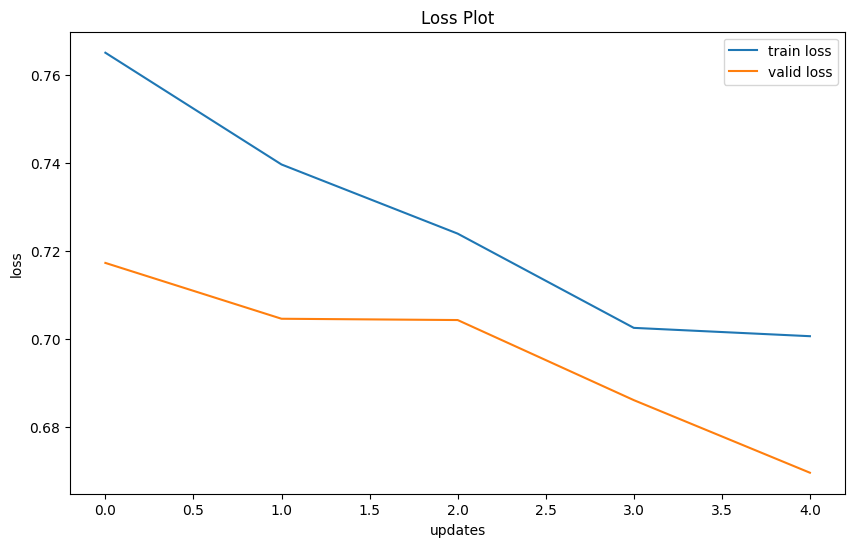

In [38]:
##Plot the training loss and the accuracy
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')
ax.set_title("Loss Plot")

Text(0.5, 1.0, 'Accuracy Plot')

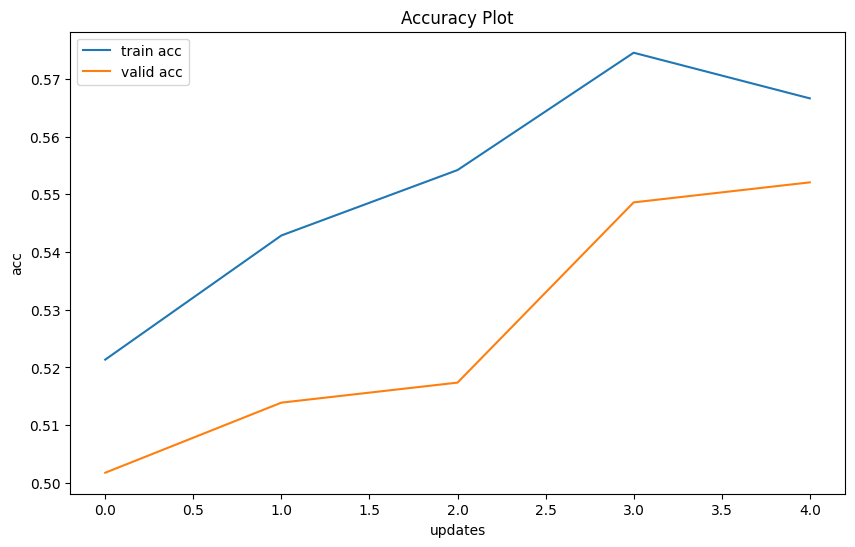

In [39]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_accs, label = 'train acc')
ax.plot(valid_accs, label = 'valid acc')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('acc')
ax.set_title("Accuracy Plot")

# Lets Try the LSTM model

In [40]:
train = PD_DATASET(train_data)
valid = PD_DATASET(valid_data)

In [41]:
import torch.nn as nn

class LSTM(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, output_dim, num_layers, bidirectional, dropout):
        super().__init__()
        #put padding_idx so asking the embedding layer to ignore padding
        self.embedding = nn.Embedding(input_dim, emb_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(emb_dim, 
                           hid_dim, 
                           num_layers=num_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout,
                           batch_first=True)
        self.fc = nn.Linear(hid_dim * 2, output_dim)
        
    def forward(self, text, text_lengths):
        #text = [batch size, seq len]
        embedded = self.embedding(text)
        
        #++ pack sequence ++
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.to('cpu'), enforce_sorted=False, batch_first=True)
        
        #embedded = [batch size, seq len, embed dim]
        packed_output, (hn, cn) = self.lstm(packed_embedded)  #if no h0, all zeroes
        
        #++ unpack in case we need to use it ++
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)
        
        #output = [batch size, seq len, hidden dim * num directions]
        #output over padding tokens are zero tensors
        
        #hidden = [num layers * num directions, batch size, hid dim]
        #cell = [num layers * num directions, batch size, hid dim]
        
        #concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        hn = torch.cat((hn[-2,:,:], hn[-1,:,:]), dim = 1)
        #hn = [batch size, hidden dim * num directions]
        
        return self.fc(hn)

In [42]:
input_dim  = len(vocab)
emb_dim    = 300 #same as above
hidden_dim = 256 #how many hidden dims do you want?
output_dim = 2 #same as above
dropout    = 0.5
num_layers = 2
bidirectional = True 

model_LSTM = LSTM(input_dim, emb_dim, hidden_dim, output_dim, num_layers, bidirectional, dropout).to(device)

In [43]:
import torch.optim as optim

lr=1e-3

#training hyperparameters
optimizer = optim.Adam(model_LSTM.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss() #

In [44]:
def train(model, loader, optimizer, criterion, loader_length):
    #write the code to train the model 
    epoch_loss = 0
    epoch_acc = 0
    model.train() #useful for batchnorm and dropout
    
    for i, (label, text, text_length) in enumerate(loader): 
        label = label.to(device) #(batch_size, )
        text = text.to(device) #(batch_size, seq len)
                
        #predict
        predictions = model(text, text_length).squeeze(1) #output by the fc is (batch_size, 1), thus need to remove this 1
        
        #calculate loss
        loss = criterion(predictions, label)
        acc  = accuracy(predictions, label)
        
        #backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
                        
    return epoch_loss / loader_length, epoch_acc / loader_length

In [45]:
def evaluate(model, loader, criterion, loader_length):
    #write the code to evaluate the model
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    
    with torch.no_grad():
        for i, (label, text, text_length) in enumerate(loader): 
            label = label.to(device) #(batch_size, )
            text  = text.to(device)  #(seq len, batch_size)

            predictions = model(text, text_length).squeeze(1) 
            
            loss = criterion(predictions, label)
            acc  = accuracy(predictions, label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / loader_length, epoch_acc / loader_length

In [46]:
train_loader_length = len(list(iter(train_loader)))
val_loader_length   = len(list(iter(valid_loader)))

In [47]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [48]:
best_valid_loss = float('inf')
num_epochs      = 5

save_path = f'lstm_{model_LSTM.__class__.__name__}.pt'

train_losses = []
train_accs = []
valid_losses = []
valid_accs = []

for epoch in range(num_epochs):
    
    start_time = time.time()

    train_loss, train_acc = train(model_LSTM, train_loader, optimizer, criterion, train_loader_length)
    valid_loss, valid_acc = evaluate(model_LSTM, valid_loader, criterion, val_loader_length)
    
    #for plotting
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        tolerance_counter = 0
        torch.save(model_LSTM.state_dict(), save_path)
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')   
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

    # Tolerance techniques, stop the model if it start to overfit.
    if tolerance_counter >= 3:
        break

    tolerance_counter = tolerance_counter + 1

Epoch: 01 | Time: 2m 4s
	Train Loss: 0.582 | Train Acc: 69.36%
	 Val. Loss: 0.436 |  Val. Acc: 81.08%
Epoch: 02 | Time: 2m 2s
	Train Loss: 0.408 | Train Acc: 82.01%
	 Val. Loss: 0.310 |  Val. Acc: 89.93%
Epoch: 03 | Time: 1m 59s
	Train Loss: 0.227 | Train Acc: 91.14%
	 Val. Loss: 0.354 |  Val. Acc: 84.55%
Epoch: 04 | Time: 1m 55s
	Train Loss: 0.113 | Train Acc: 96.16%
	 Val. Loss: 0.509 |  Val. Acc: 80.03%
Epoch: 05 | Time: 2m 3s
	Train Loss: 0.059 | Train Acc: 97.90%
	 Val. Loss: 0.469 |  Val. Acc: 84.90%


Text(0.5, 1.0, 'Loss Plot')

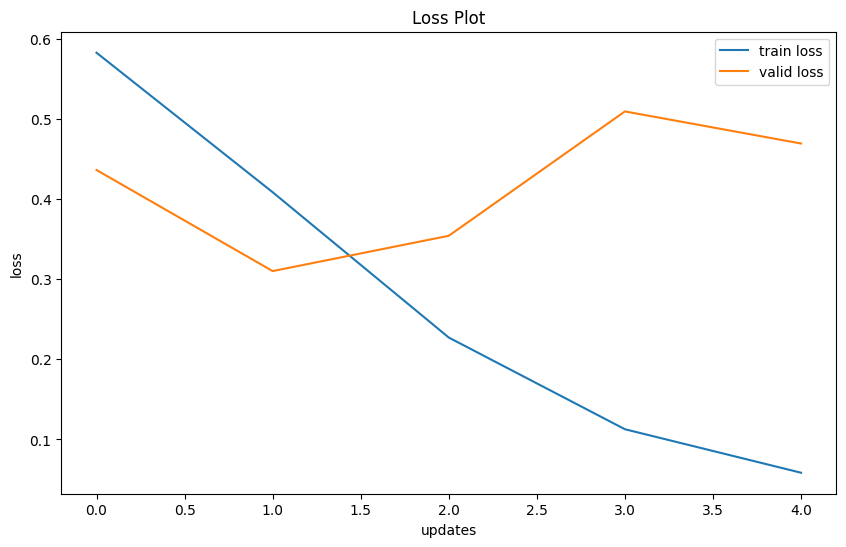

In [49]:
##Plot the losses and accuracy over all epochs
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')
ax.set_title("Loss Plot")

Text(0.5, 1.0, 'Accuracy Plot')

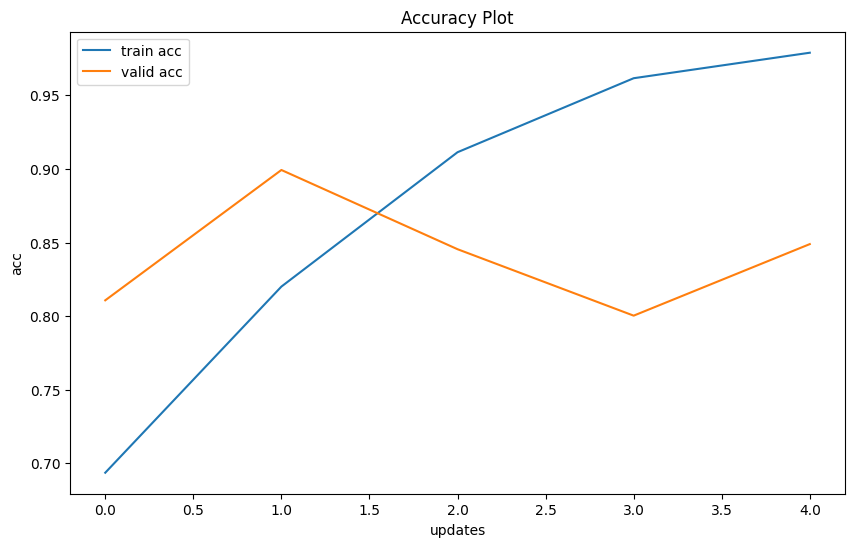

In [50]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_accs, label = 'train acc')
ax.plot(valid_accs, label = 'valid acc')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('acc')
ax.set_title("Accuracy Plot")

## Conclusion
- Compare the two models on their time and accuracy. Which one do you think did well for the disaster classification task.
- How do you think we get better results in this dataset for classification.

#### Write your answer here

- In general, we will find that the LSTM model is more accurate than the CNN model. But in terms of time, CNN is faster than LSMT. Therefore I think LSTM did well for the disaster classification task.
- I think we should have an even larger data set, because the larger the data set, the higher the accuracy will be. that is the strength of Deep Learning. In addition, we need to improve the model to get better results.